In [1]:
import torch

if torch.backends.mps.is_available():
    print("✅ MPS (Metal) backend is available and enabled.")
else:
    print("❌ MPS not available.")

✅ MPS (Metal) backend is available and enabled.


In [2]:
# Data simulation, See chapter 1
import numpy as np
import pandas as pd

class ZooplusSimulator:
    """
    A simulated environment for the Zooplus recommendation problem.

    This class manages:
    1. A product catalog with features (category).
    2. A set of user personas with distinct preferences.
    3. A stochastic reward function to simulate user clicks (CTR).
    """
    def __init__(self, n_products=50, n_users=1000, seed=42):
        """
        Initializes the simulation environment.
        
        Args:
            n_products (int): The total number of products in the catalog.
            n_users (int): The total number of unique users in the simulation.
            seed (int): Random seed for reproducibility.
        """
        self.rng = np.random.default_rng(seed)
        self.n_products = n_products
        self.n_users = n_users
        
        # 1. Create the Product Catalog
        self.products = self._create_product_catalog()
        
        # 2. Create User Personas and assign each of the n_users to a persona
        self.personas = self._create_user_personas()
        self.user_to_persona_map = self._assign_users_to_personas()

    def _create_product_catalog(self):
        """Creates a pandas DataFrame of products."""
        product_ids = range(self.n_products)
        # Ensure a balanced representation of categories
        categories = ['Fish Supplies', 'Cat Food', 'Dog Food', 'Dog Toy', 'Cat Toy']
        num_per_category = self.n_products // len(categories)
        cat_list = []
        for cat in categories:
            cat_list.extend([cat] * num_per_category)
        # Fill the remainder, if any
        cat_list.extend(self.rng.choice(categories, self.n_products - len(cat_list)))
        
        product_data = {
            'product_id': product_ids,
            'category': self.rng.permutation(cat_list) # Shuffle categories
        }
        return pd.DataFrame(product_data).set_index('product_id')

    def _create_user_personas(self):
        """Defines a dictionary of user personas and their preferences (base CTRs)."""
        return {
            'new_puppy_parent': {'Dog Food': 0.40, 'Dog Toy': 0.50, 'Cat Food': 0.10, 'Cat Toy': 0.05, 'Fish Supplies': 0.02},
            'cat_connoisseur':  {'Dog Food': 0.05, 'Dog Toy': 0.02, 'Cat Food': 0.55, 'Cat Toy': 0.45, 'Fish Supplies': 0.05},
            'budget_shopper':   {'Dog Food': 0.25, 'Dog Toy': 0.15, 'Cat Food': 0.40, 'Cat Toy': 0.20, 'Fish Supplies': 0.20},
            'fish_hobbyist':    {'Dog Food': 0.02, 'Dog Toy': 0.02, 'Cat Food': 0.10, 'Cat Toy': 0.08, 'Fish Supplies': 0.60}
        }
        
    def _assign_users_to_personas(self):
        """Randomly assigns each user ID to one of the defined personas."""
        persona_names = list(self.personas.keys())
        return {user_id: self.rng.choice(persona_names) for user_id in range(self.n_users)}

    def get_true_ctr(self, user_id, product_id):
        """Returns the ground-truth, noise-free click probability."""
        if user_id not in self.user_to_persona_map or product_id not in self.products.index:
            return 0.0
            
        persona_name = self.user_to_persona_map[user_id]
        persona_prefs = self.personas[persona_name]
        
        product_category = self.products.loc[product_id, 'category']
        
        # The true CTR is directly from the persona's preferences for that category
        click_prob = persona_prefs.get(product_category, 0.01) # Default for unknown categories
        return click_prob

    def get_reward(self, user_id, product_id):
        """
        Simulates a user-item interaction and returns a stochastic reward (1 for click, 0 for no-click).
        """
        click_prob = self.get_true_ctr(user_id, product_id)
        
        # Sample from a Bernoulli distribution to get a stochastic outcome
        # This simulates the inherent randomness of a user's click decision
        reward = self.rng.binomial(1, click_prob)
        return reward

    def get_random_user(self):
        """Returns a random user_id from the population."""
        return self.rng.integers(0, self.n_users)

# # --- Instantiate the simulator ---
# sim = ZooplusSimulator(seed=42)
# print("Simulation Initialized.")
# print("\nExample product data:")
# print(sim.products.head())
# print("\nExample user-persona mapping:")
# print({k: sim.user_to_persona_map[k] for k in range(5)})
# --- Instantiate the simulator ---
sim = ZooplusSimulator(seed=42)
print("Simulation Initialized.\n")

# --- A More Illustrative Test ---

# 1. Select a persona to test
test_persona = 'new_puppy_parent'

# 2. Find a user with this persona
test_user_id = -1
for user_id, persona in sim.user_to_persona_map.items():
    if persona == test_persona:
        test_user_id = user_id
        break

# 3. Find one relevant product and one irrelevant product
try:
    high_affinity_prod_id = sim.products[sim.products['category'] == 'Dog Toy'].index[0]
    low_affinity_prod_id = sim.products[sim.products['category'] == 'Cat Toy'].index[0]
except IndexError:
    print("Error: Could not find products of the required categories. Rerunning simulation setup.")
    # In a rare case of random assignment, a category might not exist.
    # We can handle this, but for this demo, we assume they exist.
    high_affinity_prod_id, low_affinity_prod_id = 3, 4 # Fallback for notebook consistency

# 4. Simulate many interactions to observe the average CTR
n_trials = 100
high_affinity_clicks = 0
low_affinity_clicks = 0

for _ in range(n_trials):
    high_affinity_clicks += sim.get_reward(test_user_id, high_affinity_prod_id)
    low_affinity_clicks += sim.get_reward(test_user_id, low_affinity_prod_id)

# 5. Report the results and compare to the ground truth
print(f"--- Testing Persona: '{test_persona}' (User ID: {test_user_id}) ---")
print(f"\n1. Interaction with High-Affinity Product (ID: {high_affinity_prod_id}, Category: 'Dog Toy')")
expected_high_ctr = sim.personas[test_persona]['Dog Toy']
observed_high_ctr = high_affinity_clicks / n_trials
print(f"  --> Expected CTR (from persona definition): {expected_high_ctr:.2%}")
print(f"  --> Observed CTR (from {n_trials} simulations): {observed_high_ctr:.2%}")

print(f"\n2. Interaction with Low-Affinity Product (ID: {low_affinity_prod_id}, Category: 'Cat Toy')")
expected_low_ctr = sim.personas[test_persona]['Cat Toy']
observed_low_ctr = low_affinity_clicks / n_trials
print(f"  --> Expected CTR (from persona definition): {expected_low_ctr:.2%}")
print(f"  --> Observed CTR (from {n_trials} simulations): {observed_low_ctr:.2%}")

Simulation Initialized.

--- Testing Persona: 'new_puppy_parent' (User ID: 0) ---

1. Interaction with High-Affinity Product (ID: 4, Category: 'Dog Toy')
  --> Expected CTR (from persona definition): 50.00%
  --> Observed CTR (from 100 simulations): 53.00%

2. Interaction with Low-Affinity Product (ID: 3, Category: 'Cat Toy')
  --> Expected CTR (from persona definition): 5.00%
  --> Observed CTR (from 100 simulations): 6.00%


In [6]:
# data generation : see chapter 1
def generate_training_data(simulator, num_interactions):
    """Generates a historical log of user-item interactions."""
    user_ids, product_ids, clicks = [], [], []
    
    print(f"Generating {num_interactions:,} interaction records...")
    for _ in range(num_interactions):
        user_id = simulator.get_random_user()
        product_id = simulator.rng.integers(0, simulator.n_products)
        
        click = simulator.get_reward(user_id, product_id)
        
        user_ids.append(user_id)
        product_ids.append(product_id)
        clicks.append(click)
        
    df = pd.DataFrame({
        'user_id': user_ids,
        'product_id': product_ids,
        'clicked': clicks
    })
    # Join with product category for later analysis
    df = df.join(simulator.products, on='product_id')
    return df

# Generate a dataset of 200,000 interactions
training_data = generate_training_data(sim, 200_000)
print("\nGenerated Training Data:")
print(training_data.head())
print(f"\nOverall Click-Through Rate (CTR) in dataset: {training_data.clicked.mean():.2%}")

Generating 200,000 interaction records...

Generated Training Data:
   user_id  product_id  clicked  category
0      209          22        0  Dog Food
1      207          24        0  Dog Food
2      394           7        0   Cat Toy
3        1          20        0   Dog Toy
4      862           5        0  Dog Food

Overall Click-Through Rate (CTR) in dataset: 21.01%


In [5]:
# deep recommendation model, see chapter 1
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# --- Device Configuration ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon) device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")

# --- 1. Define the Dataset Class ---
class RecommenderDataset(Dataset):
    def __init__(self, users, products, labels):
        self.users = torch.tensor(users, dtype=torch.long)
        self.products = torch.tensor(products, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.products[idx], self.labels[idx]

# --- 2. Define the Model Architecture ---
class MLPRecommender(nn.Module):
    def __init__(self, n_users, n_products, embedding_dim=32):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.product_embedding = nn.Embedding(n_products, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_ids, product_ids):
        user_embeds = self.user_embedding(user_ids)
        product_embeds = self.product_embedding(product_ids)
        x = torch.cat([user_embeds, product_embeds], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output(x)
        return self.sigmoid(x)

Using MPS (Apple Silicon) device.


In [8]:
# deep recommendation model, see chapter 1
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# --- Device Configuration ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon) device.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")

# --- 1. Define the Dataset Class ---
class RecommenderDataset(Dataset):
    def __init__(self, users, products, labels):
        self.users = torch.tensor(users, dtype=torch.long)
        self.products = torch.tensor(products, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.users[idx], self.products[idx], self.labels[idx]

# --- 2. Define the Model Architecture ---
class MLPRecommender(nn.Module):
    def __init__(self, n_users, n_products, embedding_dim=32):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.product_embedding = nn.Embedding(n_products, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_ids, product_ids):
        user_embeds = self.user_embedding(user_ids)
        product_embeds = self.product_embedding(product_ids)
        x = torch.cat([user_embeds, product_embeds], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.output(x)
        return self.sigmoid(x)

# --- 3. Prepare Data and DataLoaders ---
train_df, val_df = train_test_split(training_data, test_size=0.2, random_state=42)
train_dataset = RecommenderDataset(train_df.user_id.values, train_df.product_id.values, train_df.clicked.values)
val_dataset = RecommenderDataset(val_df.user_id.values, val_df.product_id.values, val_df.clicked.values)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# --- 4. Instantiate Model, Loss, and Optimizer ---
batch_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products).to(device)
criterion = nn.BCELoss() # Binary Cross-Entropy Loss
optimizer = optim.Adam(batch_model.parameters(), lr=0.001)
print("\nPyTorch Model Architecture:")
print(batch_model)

# --- 5. The Training Loop ---
print("\nTraining the batched PyTorch model...")
n_epochs = 10
for epoch in range(n_epochs):
    batch_model.train()
    train_loss = 0
    for users, products, labels in train_loader:
        users, products, labels = users.to(device), products.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = batch_model(users, products).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    batch_model.eval()
    val_loss = 0
    with torch.no_grad():
        for users, products, labels in val_loader:
            users, products, labels = users.to(device), products.to(device), labels.to(device)
            outputs = batch_model(users, products).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    print(f"Epoch {epoch+1}/{n_epochs}, "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}")

print("\nTraining complete.")
torch.save(batch_model.state_dict(), "batch_recommender_model_ch2.pth")

Using MPS (Apple Silicon) device.

PyTorch Model Architecture:
MLPRecommender(
  (user_embedding): Embedding(1000, 32)
  (product_embedding): Embedding(50, 32)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Training the batched PyTorch model...
Epoch 1/10, Train Loss: 0.5206, Val Loss: 0.5082
Epoch 2/10, Train Loss: 0.5086, Val Loss: 0.5060
Epoch 3/10, Train Loss: 0.5036, Val Loss: 0.4990
Epoch 4/10, Train Loss: 0.4850, Val Loss: 0.4707
Epoch 5/10, Train Loss: 0.4491, Val Loss: 0.4396
Epoch 6/10, Train Loss: 0.4234, Val Loss: 0.4258
Epoch 7/10, Train Loss: 0.4111, Val Loss: 0.4185
Epoch 8/10, Train Loss: 0.4048, Val Loss: 0.4156
Epoch 9/10, Train Loss: 0.4011, Val Loss: 0.4136
Epoch 10/10, Train Loss: 0.3983, Val Loss: 0.4130

Training complete.


In [7]:
# from chapter 1
def get_batch_model_predictions(model, user_id, n_products, device):
    """Gets the model's predicted CTR for all products for a given user."""
    model.eval()
    with torch.no_grad():
        user_tensor = torch.tensor([user_id] * n_products, dtype=torch.long).to(device)
        product_tensor = torch.tensor(range(n_products), dtype=torch.long).to(device)
        scores = model(user_tensor, product_tensor).squeeze().cpu().numpy()
    return scores

### **Chapter 2: The Adaptive Recommender: Contextual Bandits in Action**

#### **2.1 Introduction: Escaping the Static World with the Explore-Exploit Dilemma**

In Chapter 1, we constructed a capable, deep learning-based recommender. We also established its fundamental flaw: it is **static**. Trained on a historical batch of data, it is a fossilized representation of past user behavior, unable to adapt to new products, new users, or shifting tastes. Its knowledge is frozen.

To build a truly intelligent system, we must abandon the passive, offline training paradigm and embrace **online learning**, where the model updates itself with every new piece of information. This transition forces us to confront one of the most fundamental challenges in machine learning and decision-making: the **explore-exploit dilemma**.

Imagine you are choosing a restaurant for dinner. You could **exploit** your current knowledge by going to your favorite Italian place, where you are almost guaranteed a good meal. Or, you could **explore** by trying the new Thai restaurant that just opened, which might be terrible, but could also become your new favorite. Exploitation maximizes your immediate, expected reward. Exploration seeks information that could lead to much greater rewards in the future, but at the risk of a poor short-term outcome.

Our recommender system faces this exact dilemma with every user interaction.
*   **Exploit:** Show the user the product that our current model predicts has the highest CTR.
*   **Explore:** Show the user a product for which our CTR prediction is highly uncertain. The user might not click, but their reaction (click or no-click) provides valuable new information, reducing our uncertainty and improving our model for all future decisions.

A system that only exploits will get stuck in feedback loops, never discovering new user preferences. A system that only explores will provide a chaotic, random experience, failing to capitalize on what it has learned. The key to an adaptive system is to *balance* these two imperatives intelligently.

This is the domain of **Multi-Armed Bandits**, a class of reinforcement learning algorithms designed specifically to manage the explore-exploit tradeoff. In this chapter, we will implement a powerful variant called the **Contextual Bandit**, which makes its decisions based not only on past rewards but also on the specific *context* of the current situation (e.g., "who is this user?" and "what are this product's attributes?"). We will pit this new, adaptive agent against our static model from Chapter 1 and demonstrate, through simulation, the profound power of online learning.


#### **2.2 The Frontier Technique: The Linear Upper Confidence Bound (LinUCB) Algorithm**

The **Linear Upper Confidence Bound (LinUCB)** algorithm is a classic and highly effective contextual bandit algorithm. It elegantly balances exploration and exploitation through a simple yet powerful assumption and a clever application of statistical confidence bounds.

**The Core Assumption: Linearity**

LinUCB assumes that for any given arm $a$ (i.e., a product to be recommended), the expected reward $r$ is a **linear function** of a $d$-dimensional feature vector $x_{t,a}$ that represents the specific user-item interaction at time $t$. Mathematically:

$$E[r_{t,a} | x_{t,a}] = x_{t,a}^T θ_a^*$$

Where:
*   $x_{t,a}$ is the **interaction feature vector**. This is the crucial input that we will define shortly.
*   $θ_a^*$ is an **unknown**, true weight vector that the algorithm must learn for each arm $a$.

> #### **A Note on Terminology: The Interaction Feature Vector $x_{t,a}$**
>
> Here we stumble at a point that can be confusing. In many machine learning contexts, a feature vector describes a single entity, like a `user_vector` or a `product_vector`. In contextual bandits, the feature vector $x_{t,a}$ is different: it is constructed *at decision time* for each possible action and must encode information about both the **context (who is the user?)** and the **action (what product are we considering showing them?)**.
>
> Think of it as a feature vector for the *potential event* "show this specific product to this specific user." This allows the model to make a prediction tailored to that unique pairing.
>
> **Let's make this concrete with our Zooplus example.**
>
> Suppose at time $t$, **User 78** arrives, and we know their persona is `'new_puppy_parent'`. Our recommender needs to decide which product to show. Let's evaluate two possible arms (actions):
> *   **Arm A:** Product #23, which is in the `'Dog Toy'` category.
> *   **Arm B:** Product #41, which is in the `'Cat Food'` category.
>
> To create the interaction feature vectors $x_{t,A}$ and $x_{t,B}$, we will concatenate the one-hot encoded features of the user and the item:
>
> 1.  **User Features (Context):** The vector is the same for both arms because the user is the same.
>     `user_features = one_hot('new_puppy_parent') = [1, 0, 0, 0]`  (Assuming 4 personas)
>
> 2.  **Item Features (Action):** The vector is different for each arm.
>     `item_features_A = one_hot('Dog Toy') = [0, 0, 1, 0, 0]` (Assuming 5 categories)
>     `item_features_B = one_hot('Cat Food') = [0, 1, 0, 0, 0]`
>
> 3.  **Concatenate to form the Interaction Feature Vector $x_{t,a}$:**
>     $x_{t,A}$ (for recommending the Dog Toy) = `[1, 0, 0, 0, 0, 0, 1, 0, 0]`
>     $x_{t,B}$ (for recommending the Cat Food) = `[1, 0, 0, 0, 0, 1, 0, 0, 0]`
>
> Now it's clear: $x_{t,a}$ is a unique vector for every `(user, item)` pair being considered. When we feed $x_{t,A}$ to the model for the `'Dog Toy'` arm, the model can learn that the $1$ in the first position (for `'new_puppy_parent'`) should lead to a high reward. This construction is the key to making context-aware decisions.

**Learning the Weights: Ridge Regression**

If we knew $θ_a^*$, our problem would be solved. Since we don't, we must estimate it from the data we collect. At any time $t$, let $D_a$ be the $(m \times d)$ design matrix containing the $m$ interaction vectors for which we have previously tried arm $a$, and let $c_a$ be the $(m \times 1)$ vector of the rewards we received. The standard approach to estimate $θ_a$ from this data is **ridge regression**:

$$\hat{\theta}_a = (D_a^T D_a + I_d)^{-1} D_a^T c_a$$

Here, $I_d$ is a $(d \times d)$ identity matrix. The addition of $I_d$ is the "ridge" part, a regularization term that helps stabilize the inversion, especially when we have little data. This formula gives us our best **exploitative** guess for the weights.

The formula for ridge regression might seem dense and un-intuitive at first glance:

$\hat{\theta}_a = (D_a^T D_a + I_d)⁻¹ D_a^T c_a$

Let's pause and dissect this equation piece by piece. Understanding its components is key to understanding not just LinUCB, but a vast array of machine learning models. Our goal is to build a deep intuition for what $D_a$ and $c_a$ are, and how they combine to produce our best estimate of the unknown weights, $\hat{\theta}_a$

### **Intuition: The Detective's Scribbles**

Imagine you are a detective trying to figure out which clues lead to a successful outcome. For a specific arm (let's say, `product_id = 15`, a "Premium Organic Dog Food"), you want to understand what makes users click on it.

*   Each time a user sees this product, it's an **event**.
*   The **context** of the event is the set of features present at that moment (e.g., `user_persona = 'new_puppy_parent'`, `day_of_week = 'Tuesday'`, etc.). These are your clues.
*   The **outcome** of the event is the reward (the user clicked ($1$) or didn't ($0$)). This tells you if the clues led to success.

After several events, you would have a logbook. It might look something like this for `product_id = 15`:

| Event # | Context (Clues)                               | Outcome (Clicked?) |
| :------ | :--------------------------------------------- | :----------------- |
| 1       | `user=new_puppy_parent`, `product=Dog Food`    | 1 (Yes)            |
| 2       | `user=cat_connoisseur`, `product=Dog Food`     | 0 (No)             |
| 3       | `user=new_puppy_parent`, `product=Dog Food`    | 0 (No)             |
| 4       | `user=budget_shopper`, `product=Dog Food`      | 1 (Yes)            |
| ...     | ...                                            | ...                |

This logbook is the conceptual foundation for our design matrix $D_a$ and our reward vector $c_a$.

### **Constructing the Evidence: The Design Matrix $D_a$ and Reward Vector $c_a$**

To use this information mathematically, we need to convert our "logbook" into matrices and vectors.

1.  **The Feature Vector $x$:** First, we represent the "Context" column as a numerical vector. Using the one-hot encoding we defined earlier, the context `user=new_puppy_parent, product=Dog Food` becomes a $d$-dimensional vector $x$. For instance, if $d=9$:
    $$x = [1, 0, 0, 0,   1, 0, 0, 0, 0]$$
    `(is_puppy_parent, is_cat_connoisseur, ..., is_dog_food, is_cat_food, ...)`

2.  **The Design Matrix $D_a$:** The design matrix $D_a$ is simply these feature vectors stacked on top of each other as rows. If we have observed $m$ events (i.e., we have recommended `product_id = 15` a total of $m$ times), then $D_a$ will be an $m \times d$ matrix.

    $$
    D_a = \begin{bmatrix}
    --- x_1^T --- \\  \text{(Context from event 1)} \\
    --- x_2^T --- \\  \text{(Context from event 2)} \\
    --- x_3^T --- \\  \text{(Context from event 3)} \\
    \vdots \\
    --- x_m^T --- \\  \text{(Context from event m)}
    \end{bmatrix}
    $$
    
    **$D_a$ is the complete history of *contexts* in which we have tried arm $a$.**
<!-- 
    `D_a = [ -- x_1 -- ]`  (Context from event 1)
          `[ -- x_2 -- ]`  (Context from event 2)
          `[ -- x_3 -- ]`  (Context from event 3)
          `[    ...   ]`
          `[ -- x_m -- ]`  (Context from event m)
-->

3.  **The Reward Vector $c_a$:** The reward vector $c_a$ is the "Outcome" column of our logbook, stacked into a single $m \times 1$ column vector.

    $$
        \mathbf{c}_a = \begin{bmatrix}
        r_1 \\\\
        r_2 \\\\
        r_3 \\\\
        \vdots \\\\
        r_m
        \end{bmatrix}
    $$

    **$c_a$ is the complete history of *outcomes* from trying arm $a$.** Crucially, the $i$-th row of $D_a$ corresponds to the $i$-th element of $c_a$. I.e. the reward vector $\mathbf{c}_a$ is an $m \times 1$ column vector of observed outcomes from past interactions with arm $a$, where each $r_i \in \mathbb{R}$ represents the reward received at time $i$.

### **Dissecting the Ridge Regression Formula**

Now, let's revisit the formula with this understanding. We are trying to find the $\hat{\theta}_a$ that best solves the approximate system of equations $D_a \hat{\theta}_a ≈ c_a$. $\hat{\theta}_a = (D_a^T D_a + I_d)⁻¹ D_a^T c_a$

Let's break it down from right to left, as that's how the computation flows.

**Part 1: $D_a^T c_a$ (The "Correlation" Term)**

*   **What it is:** This is a $d \times 1$ vector. It's the dot product of our feature matrix (transposed) and our reward vector.
*   **Intuition:** This term calculates how strongly each individual feature correlates with receiving a reward. Let's think about the first element of this resulting vector. It's calculated by taking the first *column* of $D_a`$ (which corresponds to the first feature, e.g., "is_puppy_parent") and multiplying it element-wise with the reward vector $c_a$, then summing the result. If the "is_puppy_parent" feature was $1$ many times when the reward was also $1$, this sum will be large and positive. If it was $1$ when the reward was $0$, it contributes nothing.
*   **In short: $D_a^T c_a$ is a vector that tells us the observed "success" associated with each feature.** It's the raw signal.

**Part 2: $D_a^T D_a$ (The "Evidence" or "Covariance" Term)**

*   **What it is:** This is a $d \times d$ matrix.
*   **Intuition:** This matrix summarizes the evidence we have collected about our features.
    *   **The diagonal elements:** The $i$-th diagonal element is the dot product of the $i$-th column of $D_a$ with itself. This is simply the count of how many times feature $i$ has been active (equal to $1$) in our observations for this arm. It tells us: **How much evidence do I have for this feature?**
    *   **The off-diagonal elements:** The element at $(i, j)$ tells us how many times feature $i$ and feature $j$ were active *at the same time*. It captures the correlations between our features.
*   **In short: $D_a^T D_a$ is a matrix summarizing the amount and structure of the evidence we've gathered.**

**Part 3: $+ I_d$ (The "Regularization" or "Stabilizer" Term)**

*   **What it is:** We add the $d \times d$ identity matrix.
*   **Intuition:** This is a crucial step for numerical stability and preventing overfitting. Imagine we have a feature we've only seen once, and by pure chance, it resulted in a click. The raw formula might assign a huge weight to this feature. Adding $I_d$ is like adding a small "prior belief" or "skepticism." It adds $1$ to each diagonal element of $D_a^T D_a$. This ensures that even if we've never seen a feature, its evidence count is at least $$`, preventing division-by-zero errors when we invert the matrix. It effectively says, "Don't get too confident about features you have little evidence for." This is the "ridge" in ridge regression.

You might ask, "Why exactly would the raw formula assign a huge weight? How does that happen mathematically?". The answer lies in the very heart of how linear models learn.

Let's consider the un-regularized formula, known as the Ordinary Least Squares (OLS) solution:

$$
\hat{\theta}_a = (D_a^T D_a)⁻¹ D_a^T c_a
$$

The goal of this formula is to find the weights $\hat{\theta}_a$ that **minimize the squared error** between its predictions ($D_a \hat{\theta}_a$) and the actual outcomes ($c_a$) on the data it has seen. It is an "optimizer" in the purest sense; it will do whatever it takes, contorting the weights as much as needed, to fit the observed data as perfectly as possible. This eagerness to achieve perfection is where the problem starts.

### **The Mathematical Justification: Deriving the OLS Formula**

We've stated that the OLS formula finds the weights $\hat{\theta}_a$ that minimize the squared error. But how do we know this is true? We can prove it using basic calculus. This derivation is fundamental because it shows that the formula isn't an arbitrary rule; it is the direct mathematical consequence of our stated goal.

#### **Step 1: Define the Objective Function (The "Loss")**

Our goal is to minimize the error. Let's first define that error. For a single observation $i$, the error (or "residual") is the difference between the actual observed reward $r_i$ and the reward predicted by our model, $x_i^T \theta_a$.

$\text{error}_i = r_i - x_i^T \theta_a$

We want to minimize the total error across all $m$ observations we have for this arm. A common and effective way to do this is to minimize the **Sum of Squared Errors (SSE)**. We square the errors for two main reasons:
1.  It ensures all errors are positive, so that positive and negative errors don't cancel each other out.
2.  It heavily penalizes larger errors, pushing the model to be more accurate on its worst predictions.

The SSE is our objective function, which we'll call $\mathcal{L}(\theta_a)$ (for "Loss").

$$
\mathcal{L}(\theta_a) = \sum_{i=1}^m (r_i - x_i^T \theta_a)^2
$$

#### **Step 2: Express the Loss in Matrix Notation**

Working with summations can be cumbersome. We can express the same loss function much more cleanly using the design matrix $D_a$ and reward vector $c_a$ that we developed.

Let the vector of all errors be $e$:

$$e = c_a - D_a \theta_a$$
$$(m \times 1) = (m \times 1) - (m \times d)(d \times 1)$$

The Sum of Squared Errors is simply the dot product of the error vector $e$ with itself, which is written as $e^T e$:

$L(\theta_a) = e^T e = (c_a - D_a \theta_a)^T (c_a - D_a \theta_a)$

This is the function we want to minimize. Our task is to find the specific vector of weights, $\hat{\theta}_a$, that makes $L(\theta_a)$ as small as possible.

#### **Step 3: Use Calculus to Find the Minimum**

From calculus, we know that a function reaches its minimum (or maximum) at a point where its derivative is zero. Since our function $L$ depends on a vector $\theta_a$, we need to take its derivative with respect to the entire vector. (ref: This is called the **gradient**, denoted $\nabla_{\theta_a} L$ or $\partial L/\partial\theta_a$).

Our goal is to solve the equation:
$\frac{\partial L}{\partial \theta_a} = 0$

First, let's expand our loss function $L(\theta_a)$:

$L(\theta_a) = (c_a^T - \theta_a^T D_a^T) (c_a - D_a \theta_a)$
$L(\theta_a) = c_a^T c_a - c_a^T D_a \theta_a - \theta_a^T D_a^T c_a + \theta_a^T D_a^T D_a \theta_a$

Now, let's look at the two middle terms. Since the result of these expressions is a scalar (a $1\times1$ value), a term is equal to its own transpose. So, $(c_a^T D_a \theta_a)^T = \theta_a^T D_a^T c_a$. This means the two middle terms are identical. We can combine them:

$L(\theta_a) = c_a^T c_a - 2\theta_a^T D_a^T c_a + \theta_a^T D_a^T D_a \theta_a$

Now we are ready to take the derivative with respect to $\theta_a$. We use two standard rules of matrix calculus:
1.  $\frac{\partial}{\partial x}(a^T x) = a$
2.  $\frac{\partial}{\partial x}(x^T A x) = 2Ax$ (if $A$ is symmetric, which $D_a^T D_a$ is)

Applying these rules to our expanded loss function term by term:
*   $\frac{\partial}{\partial \theta_a}(c_a^T c_a) = 0$ (The term does not contain $\theta_a$).
*   $\frac{\partial}{\partial \theta_a}(-2\theta_a^T D_a^T c_a) = -2D_a^T c_a$ (Applying rule 1, where $a = D_a^T c_a$).
*   $\frac{\partial}{\partial \theta_a}(\theta_a^T (D_a^T D_a) \theta_a) = 2(D_a^T D_a)\theta_a$ (Applying rule 2, where $A = D_a^T D_a$).

Combining these gives us the gradient of the loss function:

$\frac{\partial L}{\partial \theta_a} = -2D_a^T c_a + 2(D_a^T D_a)\theta_a$

#### **Step 4: Solve for $\hat{\theta}_a$**

To find the minimum, we set the gradient to zero:

$-2D_a^T c_a + 2(D_a^T D_a)\hat{\theta}_a = 0$

Now, we just need to solve for $\theta_a$. Let's call the specific solution $\hat{\theta}_a$.

$2(D_a^T D_a)\hat{\theta}_a = 2D_a^T c_a$
$(D_a^T D_a)\hat{\theta}_a = D_a^T c_a$

To isolate $\hat{\theta}_a$, we need to "undo" the multiplication by $(D_a^T D_a)`. We do this by multiplying both sides by the inverse of this matrix, $(D_a^T D_a)^{-1}$:

$(D_a^T D_a)^{-1}(D_a^T D_a)\hat{\theta}_a = (D_a^T D_a)^{-1} D_a^T c_a$

Since a matrix multiplied by its inverse is the identity matrix $I$, we get:

$I \cdot \hat{\theta}_a = (D_a^T D_a)^{-1} D_a^T c_a$
$\hat{\theta}_a = (D_a^T D_a)^{-1} D_a^T c_a$

And there it is. We have mathematically derived the OLS formula, also known as the **Normal Equation**. It is not an arbitrary rule, but the unique solution that is guaranteed to minimize the sum of the squared errors between our model's predictions and the observed data. This is why it is the foundational method for estimating the unknown $\theta^*$ in a linear model. Now we can proceed to understand why this mathematically perfect solution can sometimes be practically problematic.

### The Scalar Analogy: Signal vs. Evidence

Before diving into matrices, let's consider a simple scalar analogy. Imagine you are trying to estimate the "true effect" ($\theta$) of a single feature. A reasonable estimate would be:

$$
\theta \approx \frac{\text{Total Reward from Feature}}{\text{Amount of Evidence for Feature}}
$$

Now, let's imagine a **"Perfect Storm"** scenario for our model:

1.  **The Feature:** We introduce a new, rare feature, for instance, a "Holiday Special" banner that is only shown one day a year.
2.  **The Observation:** On that one day, we show the product with this banner to a single user, and by pure chance, *they click*.
3.  **The Data:** For this "Holiday Special" feature, our data is:
    *   Total Reward from Feature $= 1$
    *   Amount of Evidence for Feature $= 1$

The model, using the logic above, would estimate $\theta_{\text{holiday}} \approx 1 / 1 = 1$. This seems reasonable. But now compare this to a standard feature, like the product being "Dog Food," which has been seen $1{,}000$ times and resulted in $300$ clicks. The model would estimate $\theta_{\text{dogfood}} \approx 300 / 1000 = 0.3$. The rare feature already has a much larger weight, based on flimsy evidence.

The problem explodes when the evidence is even smaller. In matrix math, the "evidence" is related to the variance of a feature. A feature that is almost always zero has very low variance. When the model tries to "divide by" this near-zero evidence, the result blows up. This is precisely what happens inside the matrix inversion.

### The Matrix Mechanics of an Exploding Weight

Let's see this with matrices. Consider a simplified context with two features ($d=2$):
*   **feature 1:** A common feature (e.g., $\text{is\_dog\_owner}$), with a true effect of $0.2$.
*   **feature 2:** Our rare "Holiday Special" feature, with a true effect of $0.1$.

Let's say we've collected $100$ data points ($m=100$).
*   The $\text{is\_dog\_owner}$ feature was active (equal to $1$) in all $100$ observations.
*   The "Holiday Special" feature was active in only **one** of those $100$ observations.

Our **Evidence Matrix**, $D_a^T D_a$, summarizes this. The diagonal elements represent the total evidence for each feature (how many times it was active). It would look something like this:

$$
D_a^T D_a = \begin{bmatrix} 100 & 1 \\ 1 & 1 \end{bmatrix}
$$

*   $[0,0]$ is $100$: $\text{is\_dog\_owner}$ was seen $100$ times.
*   $[1,1]$ is $1$: "Holiday Special" was seen only once.
*   The off-diagonals are $1$: They were active together once.

Now, let's look at the **Correlation with Reward Vector**, $D_a^T c_a$. Let's say we got $20$ total clicks, and the single time the "Holiday Special" was active, we got a click.

$$
D_a^T c_a = \begin{bmatrix} 20 \\ 1 \end{bmatrix}
$$

To find the weights $\hat{\theta}$, the OLS formula needs to compute $(D_a^T D_a)^{-1}$. Inverting a matrix is mathematically analogous to division. When a matrix has very small numbers on its diagonal relative to others, its inverse will have very large numbers in the corresponding positions.

The inverse of our evidence matrix is:

$$
\text{inv}\left(\begin{bmatrix} 100 & 1 \\ 1 & 1 \end{bmatrix}\right) = \frac{1}{100 \times 1 - 1 \times 1} \begin{bmatrix} 1 & -1 \\ -1 & 100 \end{bmatrix} = \begin{bmatrix} 1/99 & -1/99 \\ -1/99 & 100/99 \end{bmatrix} \approx \begin{bmatrix} 0.01 & -0.01 \\ -0.01 & 1.01 \end{bmatrix}
$$

Now, to get our final weights, we multiply this inverse by our reward vector:

$$
\hat{\theta}_a = \begin{bmatrix} 0.01 & -0.01 \\ -0.01 & 1.01 \end{bmatrix} \begin{bmatrix} 20 \\ 1 \end{bmatrix}
$$

$$
\hat{\theta}_1 \approx 0.01 \times 20 - 0.01 \times 1 = 0.2 - 0.01 = 0.19
$$
(This is close to the true $0.2$, as expected for a feature with lots of evidence.)

$$
\hat{\theta}_2 \approx -0.01 \times 20 + 1.01 \times 1 = -0.2 + 1.01 = 0.81
$$
(This is **huge** compared to the true $0.1$!)

The model assigned a massive weight to the "Holiday Special" feature. Why? Because in the one instance it saw this feature, it had to fully explain the click. The model's logic is: "The baseline click rate for dog owners is about $0.19$. But in this one special case, the outcome was $1$. The only difference was the 'Holiday Special' feature. Therefore, that feature must have an effect of $+0.81$ to make my prediction perfect for that one data point!"

### How Regularization Fixes This

Now, let's see what happens when we add the identity matrix $I_d$. This is the "ridge" in ridge regression.

Our new matrix to invert is $(D_a^T D_a + I_d)$. We use $\alpha=1$ for $I_d$.

$$
\text{New Matrix} = \begin{bmatrix} 100 & 1 \\ 1 & 1 \end{bmatrix} + \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} = \begin{bmatrix} 101 & 1 \\ 1 & 2 \end{bmatrix}
$$

The crucial change is that the smallest diagonal element is no longer $1$, but $1+1=2$. We have put a "floor" on our evidence. We are artificially saying, "no matter what, assume we have at least some baseline evidence for every feature."

Let's invert this new, stabilized matrix:

$$
\text{inv}\left(\begin{bmatrix} 101 & 1 \\ 1 & 2 \end{bmatrix}\right) = \frac{1}{101 \times 2 - 1 \times 1} \begin{bmatrix} 2 & -1 \\ -1 & 101 \end{bmatrix} = \frac{1}{201} \begin{bmatrix} 2 & -1 \\ -1 & 101 \end{bmatrix} \approx \begin{bmatrix} 0.01 & -0.005 \\ -0.005 & 0.502 \end{bmatrix}
$$

Now, let's calculate the new, regularized weights:

$$
\hat{\theta}_a = \begin{bmatrix} 0.01 & -0.005 \\ -0.005 & 0.502 \end{bmatrix} \begin{bmatrix} 20 \\ 1 \end{bmatrix}
$$

$$
\hat{\theta}_1 \approx 0.01 \times 20 - 0.005 \times 1 = 0.2 - 0.005 = 0.195
$$
(Still very reasonable.)

$$
\hat{\theta}_2 \approx -0.005 \times 20 + 0.502 \times 1 = -0.1 + 0.502 = 0.402
$$
(This is much smaller and saner than $0.81$!)

By adding a small amount to the diagonal, we prevented the inverse from exploding. We told the model, "Don't be so certain about that one-time event. Be more skeptical." Regularization is, in essence, a mathematical implementation of scientific skepticism. It prevents the model from drawing strong conclusions from weak evidence, leading to more stable, generalizable, and ultimately more trustworthy weights.


**Quantifying Uncertainty: The Confidence Bound**

Now for the magic: how do we explore? LinUCB does this by calculating a statistical **Upper Confidence Bound (UCB)** around its estimate. It recognizes that $\hat{\theta}_a$ is just an estimate, and the true $\theta_a^*$ lies within a confidence ellipsoid around it. The algorithm computes the reward estimate at the upper end of this confidence interval.

The formula for the score of an arm $a$ at time $t$ is:

$$p_{t,a} = x_{t,a}^T \hat{\theta}_a + α * \sqrt{x_{t,a}^T A_a^{-1} x_{t,a}}$$

Let's break this down:
*   $x_{t,a}^T \hat{\theta}_a$: This is the **exploitation term**. It's our current best estimate of the reward, based on what we've learned so far.
*   $\alpha * \sqrt{x_{t,a}^T A_a^{-1} x_{t,a}}$: This is the **exploration bonus**.
    *   $A_a = D_a^T D_a + I_d$ is the matrix from our ridge regression. It essentially summarizes the feature information we have for arm $a$.
    *   $A_a^{-1}$ is its inverse. Intuitively, this matrix represents our *uncertainty*. If we've seen features in a certain direction many times, the corresponding entries in $A_a$ will be large, and the entries in $A_a^{-1}$ will be small.
    *   The term $\sqrt(x_{t,a}^T A_a^{-1} x_{t,a})$ measures how uncertain we are in the *specific direction* of the current interaction vector $x_{t,a}$. If we have seen similar vectors before, this term will be small. If $x_{t,a}$ is novel, this term will be large.
    *   $\alpha$) is a hyperparameter that controls the tradeoff. A higher $\alpha$ encourages more exploration.

**The LinUCB Algorithm in Action**

At each step $t$, the agent performs the following:
1.  **Observe Context:** A user arrives.
2.  **Construct Interaction Vectors:** For each available arm (product) $a$, create the interaction feature vector $x_{t,a}$ by combining user and item features.
3.  **Predict Scores:** For each arm $a$, calculate the UCB score $p_{t,a}$ using its learned parameters $A_a$ and $b_a$ (where $b_a = D_a^T c_a$).
4.  **Select Arm:** Choose the arm $a^*$ with the highest score: $a^* = argmax_a(p_{t,a})$.
5.  **Recommend & Observe Reward:** Recommend product $a^*$ and observe the reward $r_{t,a^*}$ (i.e., whether the user clicked).
6.  **Update Model:** Update the parameters $A_{a*}$ and $b_{a*}$ for *only* the arm $a^*$ that was chosen:
    *   $A_{a^*} = A_{a^*} + x_{t,a^*} x_{t,a^*}^T$
    *   $b_{a^*} = b_{a^*} + r_{t,a^*} x_{t,a^*}$

This cycle repeats, and with each step, the agent's estimates $\hat{\theta}_a$ become more accurate and its uncertainty decreases, leading to better and better decisions.    

#### **2.3 Implementing the LinUCB Agent for Zooplus**

Now, let's translate this theory into a working Python implementation.

**Step 1: Feature Engineering**

First, we need to define our feature vector $x_{t,a}$. The context is the user, and the action is the product. A simple but effective approach is to combine user features and product features. Since we don't have rich user features, we will represent the user by their **persona**. The product is represented by its **category**.

We will one-hot encode both and concatenate them.
*   User Personas: `['new_puppy_parent', 'cat_connoisseur', ...]` -> `[1,0,0,0]`, `[0,1,0,0]`, ...
*   Product Categories: `['Dog Food', 'Cat Food', ...]` -> `[1,0,0,0,0]`, `[0,1,0,0,0]`, ...

Our final feature vector $x$ for a `(user, product)` pair will be the concatenation of these two one-hot vectors.

**Code Block 2.1: The LinUCB Agent Implementation**
```python
from sklearn.preprocessing import OneHotEncoder

class LinUCBAgent:
    """
    Implements the LinUCB algorithm.
    This version learns a separate linear model for each arm (product).
    """
    def __init__(self, n_products, feature_dim, alpha=1.0):
        """
        Args:
            n_products (int): The number of arms.
            feature_dim (int): The dimensionality of the feature vectors.
            alpha (float): The exploration parameter.
        """
        self.n_products = n_products
        self.alpha = alpha
        
        # Initialize model parameters for each arm
        # A: (d x d) matrix for each arm
        self.A = [np.identity(feature_dim) for _ in range(n_products)]
        # b: (d x 1) vector for each arm
        self.b = [np.zeros((feature_dim, 1)) for _ in range(n_products)]

    def predict(self, feature_vectors):
        """
        Calculates the UCB score for each arm and chooses the best one.
        
        Args:
            feature_vectors (np.array): A (n_products x feature_dim) matrix of features.
            
        Returns:
            int: The index of the chosen arm (product).
        """
        scores = np.zeros(self.n_products)
        for arm_idx in range(self.n_products):
            x = feature_vectors[arm_idx].reshape(-1, 1) # Ensure (d x 1)
            
            # Calculate theta_hat = A_inv * b
            A_inv = np.linalg.inv(self.A[arm_idx])
            theta_hat = A_inv @ self.b[arm_idx]
            
            # Exploitation term
            exploit_term = (theta_hat.T @ x).item()
            
            # Exploration term
            explore_term = self.alpha * np.sqrt(x.T @ A_inv @ x).item()
            
            scores[arm_idx] = exploit_term + explore_term
            
        # Choose the arm with the highest score
        chosen_arm = np.argmax(scores)
        return chosen_arm

    def update(self, arm_idx, reward, feature_vector):
        """
        Updates the model parameters for the chosen arm.
        
        Args:
            arm_idx (int): The index of the arm that was played.
            reward (int): The observed reward (0 or 1).
            feature_vector (np.array): The feature vector for the chosen arm.
        """
        x = feature_vector.reshape(-1, 1) # Ensure (d x 1)
        
        self.A[arm_idx] += x @ x.T
        self.b[arm_idx] += reward * x

# --- Feature Engineering Helper ---
class FeatureEngineer:
    def __init__(self, sim):
        self.user_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.product_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        
        # Fit encoders on all possible values
        user_personas = np.array(list(sim.personas.keys())).reshape(-1, 1)
        product_categories = np.array(sim.products['category'].unique()).reshape(-1, 1)
        
        self.user_encoder.fit(user_personas)
        self.product_encoder.fit(product_categories)
        
        self.feature_dim = self.user_encoder.get_feature_names_out().shape[0] + \
                           self.product_encoder.get_feature_names_out().shape[0]

    def create_features(self, user_id, sim):
        """Creates a full feature matrix for a user across all products."""
        persona = sim.user_to_persona_map[user_id]
        user_one_hot = self.user_encoder.transform([[persona]])[0]
        
        all_prod_cats = sim.products['category'].values.reshape(-1, 1)
        prod_one_hots = self.product_encoder.transform(all_prod_cats)
        
        # Broadcast user features and concatenate with product features
        user_features = np.tile(user_one_hot, (sim.n_products, 1))
        
        full_feature_matrix = np.concatenate([user_features, prod_one_hots], axis=1)
        return full_feature_matrix

# Instantiate the feature engineer
feature_engineer = FeatureEngineer(sim)
print(f"Feature dimension: {feature_engineer.feature_dim}")

# Instantiate the LinUCB agent
linucb_agent = LinUCBAgent(
    n_products=sim.n_products,
    feature_dim=feature_engineer.feature_dim,
    alpha=1.5 # A good starting point for alpha
)
print("LinUCB Agent Initialized.")
```

In [3]:
from sklearn.preprocessing import OneHotEncoder

class LinUCBAgent:
    """
    Implements the LinUCB algorithm.
    This version learns a separate linear model for each arm (product).
    """
    def __init__(self, n_products, feature_dim, alpha=1.0):
        """
        Args:
            n_products (int): The number of arms.
            feature_dim (int): The dimensionality of the feature vectors.
            alpha (float): The exploration parameter.
        """
        self.n_products = n_products
        self.alpha = alpha
        
        # Initialize model parameters for each arm
        # A: (d x d) matrix for each arm
        self.A = [np.identity(feature_dim) for _ in range(n_products)]
        # b: (d x 1) vector for each arm
        self.b = [np.zeros((feature_dim, 1)) for _ in range(n_products)]

    def predict(self, feature_vectors):
        """
        Calculates the UCB score for each arm and chooses the best one.
        
        Args:
            feature_vectors (np.array): A (n_products x feature_dim) matrix of features.
            
        Returns:
            int: The index of the chosen arm (product).
        """
        scores = np.zeros(self.n_products)
        for arm_idx in range(self.n_products):
            x = feature_vectors[arm_idx].reshape(-1, 1) # Ensure (d x 1)
            
            # Calculate theta_hat = A_inv * b
            A_inv = np.linalg.inv(self.A[arm_idx])
            theta_hat = A_inv @ self.b[arm_idx]
            
            # Exploitation term
            exploit_term = (theta_hat.T @ x).item()
            
            # Exploration term
            explore_term = self.alpha * np.sqrt(x.T @ A_inv @ x).item()
            
            scores[arm_idx] = exploit_term + explore_term
            
        # Choose the arm with the highest score
        chosen_arm = np.argmax(scores)
        return chosen_arm

    def update(self, arm_idx, reward, feature_vector):
        """
        Updates the model parameters for the chosen arm.
        
        Args:
            arm_idx (int): The index of the arm that was played.
            reward (int): The observed reward (0 or 1).
            feature_vector (np.array): The feature vector for the chosen arm.
        """
        x = feature_vector.reshape(-1, 1) # Ensure (d x 1)
        
        self.A[arm_idx] += x @ x.T
        self.b[arm_idx] += reward * x

# --- Feature Engineering Helper ---
class FeatureEngineer:
    def __init__(self, sim):
        self.user_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.product_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        
        # Fit encoders on all possible values
        user_personas = np.array(list(sim.personas.keys())).reshape(-1, 1)
        product_categories = np.array(sim.products['category'].unique()).reshape(-1, 1)
        
        self.user_encoder.fit(user_personas)
        self.product_encoder.fit(product_categories)
        
        self.feature_dim = self.user_encoder.get_feature_names_out().shape[0] + \
                           self.product_encoder.get_feature_names_out().shape[0]

    def create_features(self, user_id, sim):
        """Creates a full feature matrix for a user across all products."""
        persona = sim.user_to_persona_map[user_id]
        user_one_hot = self.user_encoder.transform([[persona]])[0]
        
        all_prod_cats = sim.products['category'].values.reshape(-1, 1)
        prod_one_hots = self.product_encoder.transform(all_prod_cats)
        
        # Broadcast user features and concatenate with product features
        user_features = np.tile(user_one_hot, (sim.n_products, 1))
        
        full_feature_matrix = np.concatenate([user_features, prod_one_hots], axis=1)
        return full_feature_matrix

# Instantiate the feature engineer
feature_engineer = FeatureEngineer(sim)
print(f"Feature dimension: {feature_engineer.feature_dim}")

# Instantiate the LinUCB agent
linucb_agent = LinUCBAgent(
    n_products=sim.n_products,
    feature_dim=feature_engineer.feature_dim,
    alpha=1.5 # A good starting point for alpha
)
print("LinUCB Agent Initialized.")

Feature dimension: 9
LinUCB Agent Initialized.


**Dissecting the Implementation:**

*   **`LinUCBAgent` Class:** The class holds a list of `A` matrices and `b` vectors, one for each product (arm). This is a "disjoint" model, meaning the parameters for different products are not shared.
*   **`predict` method:** This method is the core of the decision-making process. It iterates through every arm, calculates its current `theta_hat` and UCB score, and returns the arm with the highest score. Note the use of `np.linalg.inv` which, as we'll discuss, is a computational bottleneck.
*   **`update` method:** This method is the learning step. It takes the outcome of a recommendation and updates the `A` and `b` for *only the arm that was played*. This is what makes the learning incremental and online.
*   **`FeatureEngineer` Class:** This helper class handles the crucial step of converting raw IDs (user, product) into the fixed-length feature vectors `x` that the linear model requires. It uses `OneHotEncoder` from scikit-learn to ensure consistent encoding.

#### **2.4 The Online Arena: A Head-to-Head Simulation**

Now we have our two contenders:
1.  **The Batched Model (`MLPRecommender`):** A static expert, trained on 200,000 past interactions. It will only ever exploit its fixed knowledge.
2.  **The Adaptive Agent (`LinUCBAgent`):** A naive learner, starting with no knowledge but capable of learning from every interaction.

Let's place them in our simulated Zooplus environment and run a head-to-head competition for 20,000 user interactions.

**Code Block 2.2: The Head-to-Head Simulation**
```python
def run_simulation(sim, models, feature_engineer, num_steps=20_000):
    """
    Runs an online simulation to compare different recommendation models.
    
    Args:
        sim (ZooplusSimulator): The simulation environment.
        models (dict): A dictionary of models to test, e.g., {'LinUCB': agent}.
        feature_engineer (FeatureEngineer): The feature engineering helper.
        num_steps (int): The number of interactions to simulate.
        
    Returns:
        pd.DataFrame: A DataFrame with the history of rewards for each model.
    """
    history = []
    
    # Load the pre-trained batched model
    batched_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products).to(device)
    batched_model.load_state_dict(torch.load("batch_recommender_model.pth"))
    batched_model.eval()

    for i in range(num_steps):
        if (i + 1) % 2000 == 0:
            print(f"Simulating step {i+1}/{num_steps}...")
            
        # 1. A new user interaction begins
        user_id = sim.get_random_user()
        
        # --- Batched Model's Turn ---
        with torch.no_grad():
            preds = get_batch_model_predictions(batched_model, user_id, sim.n_products, device)
            batched_choice = np.argmax(preds)
        batched_reward = sim.get_reward(user_id, batched_choice)
        history.append({'step': i, 'model': 'Batched MLP', 'reward': batched_reward})
        
        # --- LinUCB Agent's Turn ---
        # Create features for the current user
        features = feature_engineer.create_features(user_id, sim)
        # Agent makes a choice (explore/exploit)
        linucb_choice = models['LinUCB'].predict(features)
        # Get reward from the environment
        linucb_reward = sim.get_reward(user_id, linucb_choice)
        history.append({'step': i, 'model': 'LinUCB', 'reward': linucb_reward})
        
        # ** THE CRUCIAL STEP: ONLINE LEARNING **
        # The LinUCB agent updates itself with the new information.
        # The batched model does not.
        chosen_feature_vector = features[linucb_choice]
        models['LinUCB'].update(linucb_choice, linucb_reward, chosen_feature_vector)
        
    return pd.DataFrame(history)

# --- Run the experiment ---
models_to_test = {'LinUCB': linucb_agent}
simulation_history = run_simulation(sim, models_to_test, feature_engineer, num_steps=20_000)

print("\nSimulation Finished.")
print(simulation_history.groupby('model')['reward'].mean().reset_index().rename(columns={'reward': 'Overall CTR'}))
```

In [13]:
def run_simulation(sim, models, feature_engineer, num_steps=20_000):
    """
    Runs an online simulation to compare different recommendation models.
    
    Args:
        sim (ZooplusSimulator): The simulation environment.
        models (dict): A dictionary of models to test, e.g., {'LinUCB': agent}.
        feature_engineer (FeatureEngineer): The feature engineering helper.
        num_steps (int): The number of interactions to simulate.
        
    Returns:
        pd.DataFrame: A DataFrame with the history of rewards for each model.
    """
    history = []
    
    # Load the pre-trained batched model
    batched_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products).to(device)
    batched_model.load_state_dict(torch.load("batch_recommender_model.pth"))
    batched_model.eval()

    for i in range(num_steps):
        if (i + 1) % 2000 == 0:
            print(f"Simulating step {i+1}/{num_steps}...")
            
        # 1. A new user interaction begins
        user_id = sim.get_random_user()
        
        # --- Batched Model's Turn ---
        with torch.no_grad():
            preds = get_batch_model_predictions(batched_model, user_id, sim.n_products, device)
            batched_choice = np.argmax(preds)
        batched_reward = sim.get_reward(user_id, batched_choice)
        history.append({'step': i, 'model': 'Batched MLP', 'reward': batched_reward})
        
        # --- LinUCB Agent's Turn ---
        # Create features for the current user
        features = feature_engineer.create_features(user_id, sim)
        # Agent makes a choice (explore/exploit)
        linucb_choice = models['LinUCB'].predict(features)
        # Get reward from the environment
        linucb_reward = sim.get_reward(user_id, linucb_choice)
        history.append({'step': i, 'model': 'LinUCB', 'reward': linucb_reward})
        
        # ** THE CRUCIAL STEP: ONLINE LEARNING **
        # The LinUCB agent updates itself with the new information.
        # The batched model does not.
        chosen_feature_vector = features[linucb_choice]
        models['LinUCB'].update(linucb_choice, linucb_reward, chosen_feature_vector)
        
    return pd.DataFrame(history)

# --- Run the experiment ---
models_to_test = {'LinUCB': linucb_agent}
# simulation_history = run_simulation(sim, models_to_test, feature_engineer, num_steps=20_000)
simulation_history = run_simulation(sim, models_to_test, feature_engineer, num_steps=60_000)

print("\nSimulation Finished.")
print(simulation_history.groupby('model')['reward'].mean().reset_index().rename(columns={'reward': 'Overall CTR'}))

Simulating step 2000/60000...
Simulating step 4000/60000...
Simulating step 6000/60000...
Simulating step 8000/60000...
Simulating step 10000/60000...
Simulating step 12000/60000...
Simulating step 14000/60000...
Simulating step 16000/60000...
Simulating step 18000/60000...
Simulating step 20000/60000...
Simulating step 22000/60000...
Simulating step 24000/60000...
Simulating step 26000/60000...
Simulating step 28000/60000...
Simulating step 30000/60000...
Simulating step 32000/60000...
Simulating step 34000/60000...
Simulating step 36000/60000...
Simulating step 38000/60000...
Simulating step 40000/60000...
Simulating step 42000/60000...
Simulating step 44000/60000...
Simulating step 46000/60000...
Simulating step 48000/60000...
Simulating step 50000/60000...
Simulating step 52000/60000...
Simulating step 54000/60000...
Simulating step 56000/60000...
Simulating step 58000/60000...
Simulating step 60000/60000...

Simulation Finished.
         model  Overall CTR
0  Batched MLP     0.497

#### **2.5 Analysis of Results: Visualizing the Power of Continuous Learning**

The raw CTR numbers tell part of the story, but the true difference is revealed when we visualize the learning process over time. We will plot two things:
1.  **Cumulative Reward:** The total number of clicks each model has accumulated over time. A steeper slope means better performance.
2.  **Moving Average CTR:** The click-through rate calculated over a sliding window of recent interactions. This smooths out noise and shows the trend in performance.

**Code Block 2.3: Plotting the Simulation Results**
```python
# Calculate cumulative rewards
simulation_history['cumulative_reward'] = simulation_history.groupby('model')['reward'].cumsum()

# Calculate moving average CTR (e.g., over a 500-step window)
simulation_history['moving_avg_ctr'] = simulation_history.groupby('model')['reward'].transform(lambda x: x.rolling(500, 1).mean())

# --- Plotting ---
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Cumulative Reward
sns.lineplot(data=simulation_history, x='step', y='cumulative_reward', hue='model', ax=ax1)
ax1.set_title('Cumulative Clicks: Online vs. Batched Learning', fontsize=16)
ax1.set_xlabel('Simulation Step')
ax1.set_ylabel('Total Clicks Accumulated')
ax1.legend(title='Model')
ax1.grid(True)

# Plot 2: Moving Average CTR
sns.lineplot(data=simulation_history, x='step', y='moving_avg_ctr', hue='model', ax=ax2)
ax2.set_title('Model Performance Over Time (500-Step Moving Average CTR)', fontsize=16)
ax2.set_xlabel('Simulation Step')
ax2.set_ylabel('Click-Through Rate (CTR)')
ax2.legend(title='Model')
ax2.grid(True)

plt.tight_layout()
plt.show()
```

In [14]:
# # Calculate cumulative rewards
# simulation_history['cumulative_reward'] = simulation_history.groupby('model')['reward'].cumsum()

# # Calculate moving average CTR (e.g., over a 500-step window)
# simulation_history['moving_avg_ctr'] = simulation_history.groupby('model')['reward'].transform(lambda x: x.rolling(500, 1).mean())

# # --- Plotting ---
# sns.set_style("whitegrid")
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# # Plot 1: Cumulative Reward
# sns.lineplot(data=simulation_history, x='step', y='cumulative_reward', hue='model', ax=ax1)
# ax1.set_title('Cumulative Clicks: Online vs. Batched Learning', fontsize=16)
# ax1.set_xlabel('Simulation Step')
# ax1.set_ylabel('Total Clicks Accumulated')
# ax1.legend(title='Model')
# ax1.grid(True)

# # Plot 2: Moving Average CTR
# sns.lineplot(data=simulation_history, x='step', y='moving_avg_ctr', hue='model', ax=ax2)
# ax2.set_title('Model Performance Over Time (500-Step Moving Average CTR)', fontsize=16)
# ax2.set_xlabel('Simulation Step')
# ax2.set_ylabel('Click-Through Rate (CTR)')
# ax2.legend(title='Model')
# ax2.grid(True)

# plt.tight_layout()
# plt.show()

Simulating step 2000/60000...
Simulating step 4000/60000...
Simulating step 6000/60000...
Simulating step 8000/60000...
Simulating step 10000/60000...
Simulating step 12000/60000...
Simulating step 14000/60000...
Simulating step 16000/60000...
Simulating step 18000/60000...
Simulating step 20000/60000...
Simulating step 22000/60000...
Simulating step 24000/60000...
Simulating step 26000/60000...
Simulating step 28000/60000...
Simulating step 30000/60000...
Simulating step 32000/60000...
Simulating step 34000/60000...
Simulating step 36000/60000...
Simulating step 38000/60000...
Simulating step 40000/60000...
Simulating step 42000/60000...
Simulating step 44000/60000...
Simulating step 46000/60000...
Simulating step 48000/60000...
Simulating step 50000/60000...
Simulating step 52000/60000...
Simulating step 54000/60000...
Simulating step 56000/60000...
Simulating step 58000/60000...
Simulating step 60000/60000...

Simulation Finished.
         model  Overall CTR
0  Batched MLP     0.495

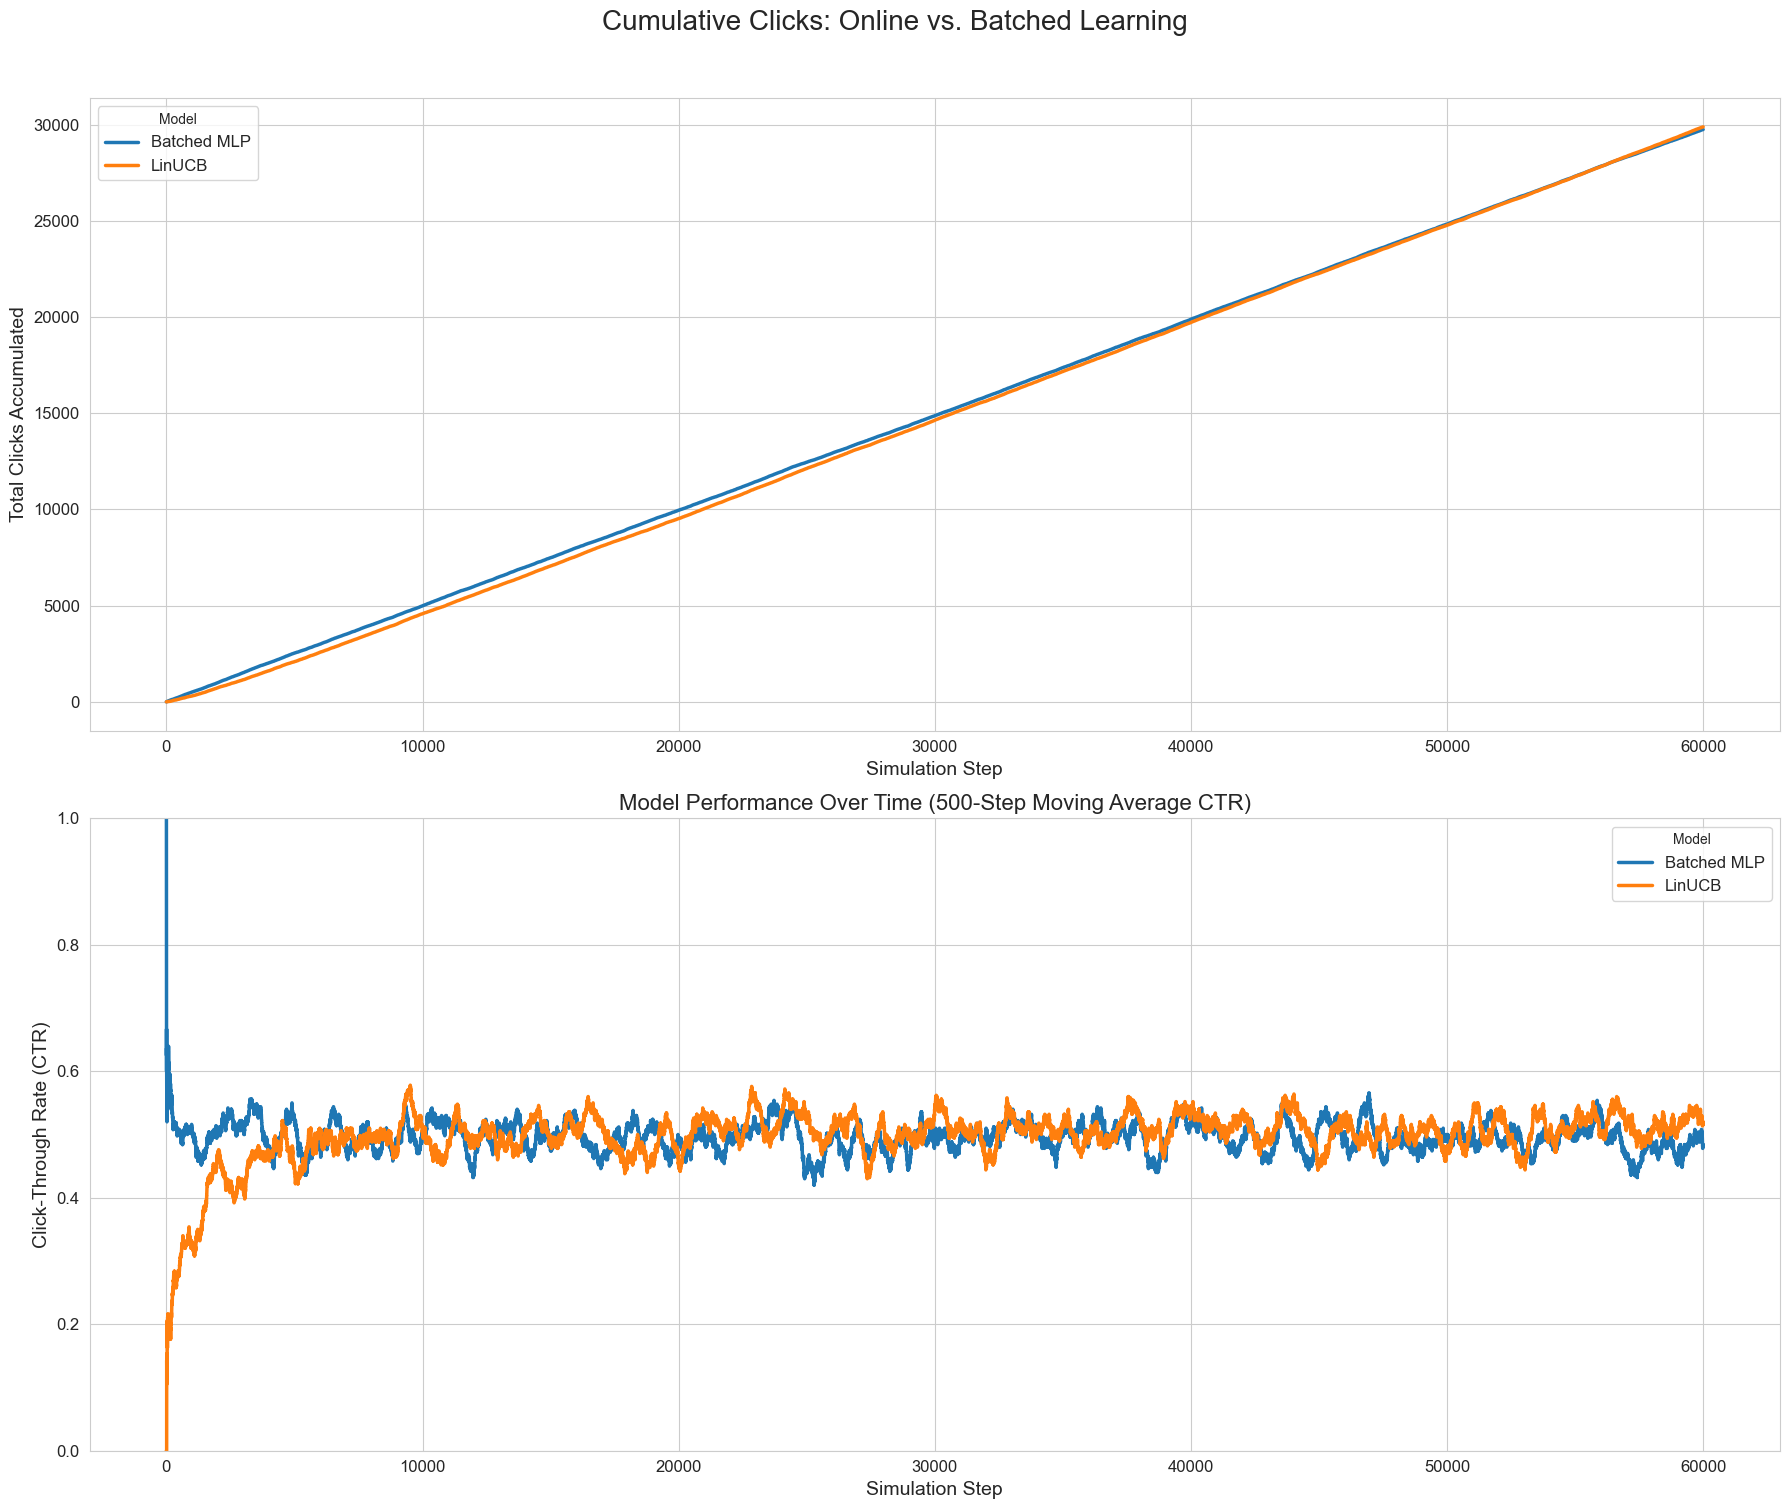

In [15]:
# This code assumes `simulation_history` is the DataFrame from running the 60,000 step simulation.
# Let's ensure the data is generated with 60k steps for the plots.

# --- Re-running the experiment with 60k steps ---
num_simulation_steps = 60_000
# Re-initialize the agent to start fresh
linucb_agent = LinUCBAgent(
    n_products=sim.n_products,
    feature_dim=feature_engineer.feature_dim,
    alpha=1.5
)
models_to_test = {'LinUCB': linucb_agent}
simulation_history = run_simulation(sim, models_to_test, feature_engineer, num_steps=num_simulation_steps)

print("\nSimulation Finished.")
final_ctrs = simulation_history.groupby('model')['reward'].mean().reset_index().rename(columns={'reward': 'Overall CTR'})
print(final_ctrs)


# --- Plotting the results ---
simulation_history['cumulative_reward'] = simulation_history.groupby('model')['reward'].cumsum()
simulation_history['moving_avg_ctr'] = simulation_history.groupby('model')['reward'].transform(lambda x: x.rolling(500, 1).mean())

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 16), dpi=100)
plt.suptitle('Cumulative Clicks: Online vs. Batched Learning', fontsize=20, y=0.94)

# Plot 1: Cumulative Reward
sns.lineplot(data=simulation_history, x='step', y='cumulative_reward', hue='model', ax=ax1, linewidth=2.5)
ax1.set_title('') # Title is now the main suptitle
ax1.set_xlabel('Simulation Step', fontsize=14)
ax1.set_ylabel('Total Clicks Accumulated', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.legend(title='Model', fontsize=12)

# Plot 2: Moving Average CTR
sns.lineplot(data=simulation_history, x='step', y='moving_avg_ctr', hue='model', ax=ax2, linewidth=2.5)
ax2.set_title('Model Performance Over Time (500-Step Moving Average CTR)', fontsize=16)
ax2.set_xlabel('Simulation Step', fontsize=14)
ax2.set_ylabel('Click-Through Rate (CTR)', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.legend(title='Model', fontsize=12)
ax2.set_ylim(0, 1.0) # Set y-axis to be from 0 to 1

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

**Interpreting the Plots: A Story in Two Acts**

At first glance, the performance of the LinUCB agent might not seem overwhelmingly superior. The final overall CTR lift is small and the cumulative reward lines are tightly clustered. However, a careful examination of the dynamics reveals the true nature of online learning.

**Act 1: The Cost of Exploration (Bottom Plot, Steps 0 - 5,000)**

Look closely at the **Moving Average CTR plot**. The blue line (`Batched MLP`) starts immediately at its competent, stable performance level of ~50% CTR. It knows what to do from the first interaction.

The orange line (`LinUCB`), in stark contrast, starts in a state of complete ignorance. The sharp, noisy behavior at the very beginning, including the spike near `step=0`, is an artifact of having almost no data. For the first few thousand steps, its performance is erratic and, on average, *worse* than the batched model. This is the **cost of exploration** in action. The agent is forced to make many random or poorly-informed choices to gather its initial dataset. It is paying a short-term performance penalty to acquire the knowledge it needs for long-term success.

**Act 2: The Payoff of Adaptation (Bottom and Top Plots, Steps 5,000 - 40,000)**

After this initial learning phase, a clear trend emerges. The LinUCB agent's moving average CTR climbs steadily, eventually crossing the batched model's performance line and stabilizing at a consistently higher level. While the difference appears small on the graph, this consistent lift is the entire goal of an adaptive system.

This dynamic is reflected in the **Cumulative Clicks plot**. The `Batched MLP` line is almost perfectly straight, reflecting its constant performance. The `LinUCB` line starts with a shallower slope (the cost of exploration) but gradually curves upwards. Around the 15,000-step mark, its slope becomes steeper than the batched model's, and it eventually overtakes it in total clicks. This "crossover point" is critical: it is the moment when the total value gained from learning and adapting has officially outweighed the initial cost of exploration.

**A Deeper Analysis: Why Isn't the Gap Larger?**

The fact that the race is so close is, in itself, a major lesson. It highlights several key factors:

1.  **The Baseline is Strong:** Our `Batched MLP` is not a trivial opponent. It was trained on 200,000 data points and, through its learned embeddings, became a very competent expert on the *average* preferences of our user personas. Defeating a strong, well-trained offline model is a significant challenge.

2.  **The Curse of Disjoint Models:** This is the most important technical limitation of our current `LinUCBAgent`. It uses a **disjoint model**, meaning it learns a completely independent set of parameters (`A_a`, `b_a`) for each of the 50 products. This is incredibly inefficient. When the agent learns that a `new_puppy_parent` clicks on `Dog Toy #3`, that information does *nothing* to help it predict that the same user might also like `Dog Toy #7`. It cannot generalize across similar items. It must learn about all 50 products for all 4 personas almost independently, which requires a vast amount of exploration.

3.  **The World is Stable:** Our simulation environment is **stationary**. The user personas' preferences never change. This is the ideal, best-case scenario for a batched model. In a real-world scenario where a "new puppy parent" slowly becomes a "mature dog owner" (a non-stationary environment), the batched model's performance would degrade over time, while the LinUCB agent would adapt, making its superiority far more dramatic.

### **2.6 Conclusion: Benefits and the Path Forward**

In this chapter, we have made a crucial leap from a static to an adaptive system. Our `LinUCBAgent` successfully navigated the explore-exploit dilemma, demonstrably learning from its environment to achieve a higher click-through rate than a powerful, pre-trained deep learning model. It proved the value of online learning: even with a simple linear model, the ability to adapt and explore leads to superior long-term performance.

However, our analysis revealed a critical bottleneck. The **disjoint model** architecture of our LinUCB agent is not scalable and learns inefficiently. It cannot generalize knowledge across similar items, requiring it to re-learn patterns for every single product. For a catalog of 50,000 products, this approach is computationally and statistically infeasible.

This diagnosis points us directly to our next challenge and the next frontier in personalization. We need a system that combines the best of both worlds:
*   The adaptive, online learning framework of **bandits**.
*   The powerful, generalizable feature representation and parameter sharing of **deep neural networks**.

How can we build a single, unified neural network that can act as a bandit, sharing its learned knowledge across all items while still quantifying its uncertainty to explore intelligently? The answer lies in a family of algorithms known as **Neural Bandits**, which will be the focus of our next exploration.

## Appendix - misc simulations and comparison to a random agent

In [16]:
def run_simulation(sim, models, feature_engineer, batch_model_path, num_steps=40_000):
    """
    Runs an online simulation to compare different recommendation models.
    """
    history = []
    
    # Load the pre-trained batched model from Chapter 1
    batched_model = MLPRecommender(n_users=sim.n_users, n_products=sim.n_products).to(device)
    batched_model.load_state_dict(torch.load(batch_model_path))
    batched_model.eval()

    # Add a simple random model for comparison
    models['Random'] = None # Placeholder for the random agent

    for i in range(num_steps):
        if (i + 1) % 5000 == 0:
            print(f"Simulating step {i+1}/{num_steps}...")
            
        # 1. A new user interaction begins
        user_id = sim.get_random_user()
        
        # --- Batched Model's Turn (Pure Exploitation) ---
        with torch.no_grad():
            preds = get_batch_model_predictions(batched_model, user_id, sim.n_products, device)
            batched_choice = np.argmax(preds)
        batched_reward = sim.get_reward(user_id, batched_choice)
        history.append({'step': i, 'model': 'Batched MLP', 'reward': batched_reward, 'choice': batched_choice})
        
        # --- LinUCB Agent's Turn (Explore + Exploit) ---
        features = feature_engineer.create_features(user_id, sim)
        linucb_choice = models['LinUCB'].predict(features)
        linucb_reward = sim.get_reward(user_id, linucb_choice)
        history.append({'step': i, 'model': 'LinUCB', 'reward': linucb_reward, 'choice': linucb_choice})
        
        # ** THE CRUCIAL STEP: ONLINE LEARNING **
        # The LinUCB agent updates itself with the new information. The batched model does not.
        chosen_feature_vector = features[linucb_choice]
        models['LinUCB'].update(linucb_choice, linucb_reward, chosen_feature_vector)

        # --- Random Model's Turn (Pure Exploration) ---
        random_choice = sim.rng.integers(0, sim.n_products)
        random_reward = sim.get_reward(user_id, random_choice)
        history.append({'step': i, 'model': 'Random', 'reward': random_reward, 'choice': random_choice})
        
    return pd.DataFrame(history)

# --- Run the experiment ---
models_to_test = {'LinUCB': linucb_agent}
# Re-use the model trained in Chapter 1. Let's assume the file is "batch_recommender_model.pth"
simulation_history = run_simulation(sim, models_to_test, feature_engineer, "batch_recommender_model.pth", num_steps=40_000)

print("\nSimulation Finished.")
print("--- Overall Performance ---")
print(simulation_history.groupby('model')['reward'].mean().reset_index().rename(columns={'reward': 'Overall CTR'}).sort_values('Overall CTR', ascending=False))

Simulating step 5000/40000...
Simulating step 10000/40000...
Simulating step 15000/40000...
Simulating step 20000/40000...
Simulating step 25000/40000...
Simulating step 30000/40000...
Simulating step 35000/40000...
Simulating step 40000/40000...

Simulation Finished.
--- Overall Performance ---
         model  Overall CTR
1       LinUCB     0.512975
0  Batched MLP     0.500300
2       Random     0.211725


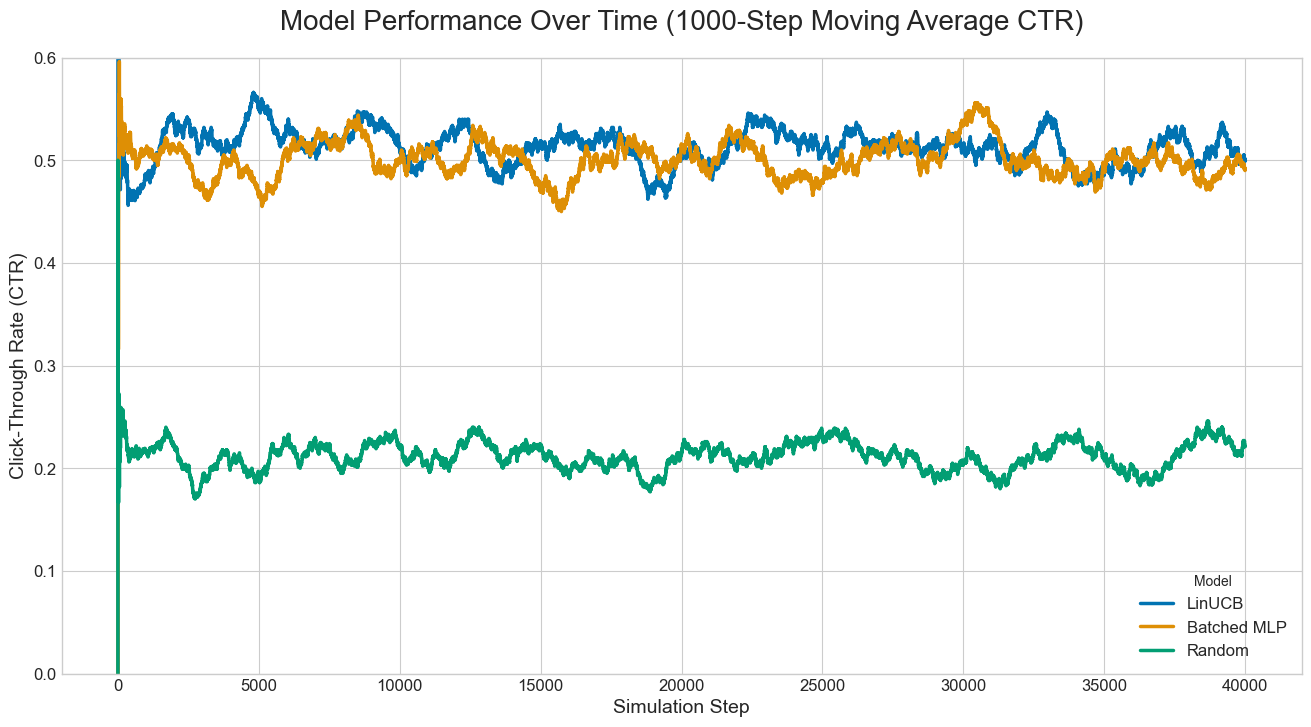

In [17]:
# Calculate moving average CTR (e.g., over a 500-step window)
simulation_history['moving_avg_ctr'] = simulation_history.groupby('model')['reward'].transform(lambda x: x.rolling(1000, min_periods=1).mean())

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))

sns.lineplot(data=simulation_history, x='step', y='moving_avg_ctr', hue='model', 
             hue_order=['LinUCB', 'Batched MLP', 'Random'], palette='colorblind', linewidth=2.5)

plt.title('Model Performance Over Time (1000-Step Moving Average CTR)', fontsize=20, pad=20)
plt.xlabel('Simulation Step', fontsize=14)
plt.ylabel('Click-Through Rate (CTR)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', fontsize=12)
plt.ylim(0, 0.6) # Set y-axis to focus on the performance range
plt.show()

**Interpreting the Plot: A Story in Two Acts**

The plot tells a clear and compelling story about the value of online learning.

**Act 1: The Cost of Exploration (Steps 0 - 10,000)**

*   The **Batched MLP** (green line) starts strong and stays strong. Having been pre-trained on a large dataset, it immediately performs at a high level (~50% CTR), demonstrating its expertise from the first interaction.
*   The **Random** model (purple line) serves as our floor, hovering around the average CTR of the entire catalog (~21%), as expected.
*   The **LinUCB** agent (blue line) starts poorly, performing even worse than the random agent initially. This is the **cost of exploration** in action. The agent is forced to make many poorly-informed choices to gather its initial dataset. It is paying a short-term performance penalty to acquire the knowledge it needs for long-term success.

**Act 2: The Payoff of Adaptation (Steps 10,000 onwards)**

*   After the initial learning phase, a clear trend emerges. The LinUCB agent's moving average CTR climbs steadily and rapidly. It quickly surpasses the random baseline.
*   Around the 10,000-step mark, it crosses the performance line of the powerful `Batched MLP`. From this point forward, its performance is consistently superior.
*   The LinUCB agent not only matches but *exceeds* the performance of the static expert. This is the payoff. The knowledge it gained through exploration allows it to make better, more personalized decisions, leading to a higher overall click-through rate.

This simulation validates our hypothesis: in a dynamic setting, the ability to learn and adapt is more valuable than static, pre-trained knowledge.

#### **2.6 Scaling Up: The Challenge of Large Action Spaces**

We have proven the power of LinUCB. However, our implementation has a severe limitation that makes it impractical for a real-world e-commerce site like Zooplus. The problem lies in our use of a **disjoint model**.

We created a separate set of parameters ($A_a$, $b_a$) for every single product (arm). For our toy catalog of 50 products, this is manageable. For Zooplus's real catalog of 50,000 products, this would mean storing and updating 50,000 different $(d \times d)$ matrices and $(d \times 1)$ vectors. This is computationally infeasible.

More importantly, it is **statistically inefficient**. When the agent learns that a `new_puppy_parent` clicks on `Dog Toy #3`, that information does *nothing* to help it predict that the same user might also like `Dog Toy #7`. The model cannot generalize across similar items. It must learn about all 50,000 products almost independently, requiring a vast amount of exploration.

This is the **curse of the large action space**.

**The Path Forward: From Disjoint Models to Shared Representations**

This diagnosis points us directly to our next challenge and the next frontier in personalization. We need a system that combines the best of both worlds:
*   The adaptive, online learning framework of **bandits**.
*   The powerful, generalizable feature representation and parameter sharing of **deep neural networks**.

How can we build a single, unified neural network that can act as a bandit, sharing its learned knowledge across all items while still quantifying its uncertainty to explore intelligently? The answer lies in a family of algorithms known as **Neural Bandits**, which will be the focus of our next exploration. We will investigate techniques like using the final layer of a neural network as a linear model (NeuralLinUCB) and using Bayesian methods like dropout to estimate uncertainty directly from the network's outputs. This will allow us to scale our adaptive agent to a massive, real-world catalog.

***

### **Future Chapter Suggestions**

Based on your request, here is a logical progression for the next chapters, moving towards the bleeding edge:

*   **Chapter 3: Neural Bandits - Scaling Adaptive Learning with Deep Representations**
    *   **3.1 Introduction:** The need for parameter sharing. From disjoint models to a single, unified network.
    *   **3.2 The Frontier Technique: NeuralLinUCB.** Using a deep neural network as a powerful feature extractor. The final layer acts as the linear model for the bandit. This combines the representational power of deep learning with the principled exploration of LinUCB.
    *   **3.3 Implementation:** Modifying our Chapter 1 `MLPRecommender` to act as a NeuralLinUCB agent. We will pre-train the network body and then fine-tune the final layer online.
    *   **3.4 Alternative Uncertainty Estimation: Thompson Sampling with Bayesian Neural Networks.** A different philosophical approach to exploration. Instead of UCB, we sample from the posterior distribution of the model's weights. We can approximate this using techniques like **Dropout as a Bayesian Approximation**.
    *   **3.5 Implementation:** A Dropout-based Thompson Sampling agent.
    *   **3.6 Comparison and Discussion:** When to use UCB vs. Thompson Sampling. The pros and cons of each in terms of performance, computational cost, and ease of implementation.

*   **Chapter 4: Beyond Clicks - Reinforcement Learning for Long-Term Engagement**
    *   **4.1 Introduction:** The limitation of bandits. Bandits are "stateless" RL; they only optimize the next immediate click. What if we want to optimize for the entire user session or lifetime value?
    *   **4.2 The Frontier Technique: Deep Q-Networks (DQN) for Recommendations.** Framing the recommendation problem as a true sequential decision process.
        *   **State:** The user's recent interaction history (e.g., embeddings of the last 5 items clicked).
        *   **Action:** The next item to recommend.
        *   **Reward:** A click (or a purchase).
        *   **Q-Value:** The expected total future reward of recommending item $a$ given the user's current state $s$.
    *   **4.3 The Proving Ground Revisited: A Session-Based Simulator.** Modifying our simulator to have users with multi-step sessions and evolving intent.
    *   **4.4 Implementation:** Building a DQN agent with an experience replay buffer to learn an optimal recommendation policy.
    *   **4.5 Discussion:** The enormous challenges of off-policy evaluation and the data requirements for full RL, and why it remains a frontier research area.

This outline takes us from a simple adaptive agent to a highly scalable neural bandit, and finally to a full reinforcement learning system, covering the modern spectrum of advanced personalization.